In [17]:
%matplotlib notebook
import gym
import gym_watten
from gym_watten.envs.watten_env import Color, Value
import numpy as np
from time import sleep
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pydot_ng as pydot
from io import BytesIO
import pickle

In [2]:
env = gym.make("Watten-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_watten.envs.watten_env.WattenEnv'>' has deprecated methods. Compatibility code invoked.


In [42]:
EPISODES = 75
MCTS_SIMS = 100
MEMORY_SIZE = 30000

BATCH_SIZE = 256
TRAINING_LOOPS = 100

EPSILON = 0.2
ALPHA = 0.8

# Search

In [4]:
def search(obs):
    state = env.get_state()
    n = len(env.players[env.current_player].hand_cards)   
    p = 0
    current_player = env.current_player
    distr = np.zeros((n,))
    
    for i in range(n):
        card_id = env.players[env.current_player].hand_cards[i].id
        obs, rew, is_done, _ = env.step(card_id)
        
        if is_done:
            distr[i] = (rew[0] > 0)
        else:
            distr[i] = ((1 - search(obs)[0]) if current_player != env.current_player else search(obs)[0])
        env.set_state(state)
        p += distr[i]
        
    return distr.max(), distr

# MCTS

In [31]:
class State:
    def __init__(self, p, env_state, current_player, end_v=0, is_root=True):
        self.childs = []
        self.n = 0
        self.w = 0
        self.v = 0
        self.p = p
        self.env_state = env_state
        self.end_v = end_v
        self.current_player = current_player
        self.is_root = is_root
        
    def is_leaf_node(self):
        return len(self.childs) == 0
    
    def size(self):
        size = 1
        for child in self.childs:
            size += child.size()
        return size
    
def mcts_sample(state, use_model=True):
    
    if state.is_leaf_node():
        if state.end_v != 0:
            v = state.end_v
        else:
            env.set_state(state.env_state)

            if use_model:
                p, v = model.predict_single(env.regenerate_obs())
            else:
                p, v = [1] *32, [0]
                
            hand_cards = env.players[env.current_player].hand_cards[:]        
            current_player = env.current_player
            for card in hand_cards:
                obs, rew, is_done, _ = env.step(card.id)

                new_state = State(p[card.id], env.get_state(), env.current_player, 0 if not is_done else (1 if rew[0] > 0 else -1) * (-1 if env.current_player != current_player else 1), False)
                state.childs.append(new_state)

                env.set_state(state.env_state)

            v = v[0]  
            state.v = v
    else:
        n_sum = 0
        for child in state.childs:
            n_sum += child.n
            
        if state.is_root:
            epsilon = EPSILON
            nu = np.random.dirichlet([ALPHA] * len(state.childs))
        else:
            epsilon = 0
            nu = [0] * len(state.childs)

        max_u = 0
        max_child = None
        i = 0
        rand_i = 2 if state.is_root else random.randint(0, len(state.childs) - 1)
        for child in state.childs:
            if child.end_v != 0:
                u = child.end_v
            elif child.n > 0:
                u = child.w / child.n 
            else:
                u = 0
            
            u *= (-1 if child.current_player != state.current_player else 1)
            
            u += ((1 - epsilon) * child.p + epsilon * nu[i]) * np.sqrt(n_sum) / (1 + child.n)

            if max_child is None or u > max_u:
                max_u, max_child = u, child
            i += 1
        v = mcts_sample(max_child, use_model) * (-1 if max_child.current_player != state.current_player else 1)
        
    state.w += v 
    state.n += 1
    return v

def mcts_game_step(root, steps=MCTS_SIMS, use_model=True):
    for i in range(steps):
        mcts_sample(root, use_model)
        
    p = [child.n for child in root.childs]
    p /= np.sum(p)
    return np.random.choice(np.arange(0, len(p)), p=p), p
    
def mcts_game():
    global sample_inputs, sample_outputs, next_index, number_of_samples
    obs = env.reset()
    root = State(1, env.get_state(), env.current_player)
    is_done = False
    start_index = next_index
    indices = []
    
    while not is_done:
        indices.append(next_index)
        sample_inputs[0][next_index] = np.array(obs[0])
        sample_inputs[1][next_index] = np.array(obs[1])
        sample_outputs[1][next_index] = 1 if env.current_player is 0 else -1
        
        game_state = env.get_state()
        a, p = mcts_game_step(root)
        env.set_state(game_state)
        
        for i, card in enumerate(env.players[env.current_player].hand_cards):
            sample_outputs[0][next_index][card.id] = p[i]    
        
        next_index += 1
        next_index %= MEMORY_SIZE
        number_of_samples = max(number_of_samples, next_index)
        
        last_player = env.current_player
        obs, rew, is_done, _ = env.step(env.players[env.current_player].hand_cards[a].id)
        root = root.childs[a]
        root.is_root = True
                
    for i in indices:
        sample_outputs[1][i][0] *= (1 if last_player is 0 else -1) * (1 if rew[0] > 0 else -1)
        
def mcts_generate():
    
    for i in tqdm(range(EPISODES)):
        mcts_game()
    #postprocess_samples()

def reset_samples():
    global sample_outputs, sample_inputs, next_index, number_of_samples
    sample_outputs = [np.zeros((MEMORY_SIZE, 32), dtype=float), np.zeros((MEMORY_SIZE, 1), dtype=int)]
    sample_inputs = [np.zeros((MEMORY_SIZE, 4, 8, 2), dtype=int), np.zeros((MEMORY_SIZE, 4), dtype=int)]
    next_index = 0
    number_of_samples = 0
    
def draw_tree(root):
    dot = pydot.Dot()
    dot.set('rankdir', 'TB')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')

    create_nodes(root, dot)

   # print("Root: " + str(root.end_v if root.n is 0 else root.w / root.n) + " / " + str(root.n))
   # for child in root.childs:
   #     print( str(child.end_v if child.n is 0 else child.w / child.n) + " / " + str(child.n) + " p: " + str(child.p))

    # render pydot by calling dot, no file saved to disk
    png_str = dot.create_png(prog='dot')

    # treat the dot output string as an image file
    sio = BytesIO()
    sio.write(png_str)
    sio.seek(0)
    
    # plot the image
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.imshow(plt.imread(sio), interpolation="bilinear")
    
def create_nodes(root, dot, id=0):    
    text = "N: " + str(root.n) + " (" + str(root.current_player) + ')\n'
    text += "Q: " + str(root.end_v if root.n is 0 else root.w / root.n) + '\n'
    text += "P: " + str(root.p) + '\n'
    text += "V: " + str(root.v)
    
    node = pydot.Node(str(id), label=text)
    dot.add_node(node)    
    id += 1

    for child in root.childs:
        child_node, id = create_nodes(child, dot, id)
        dot.add_edge(pydot.Edge(node.get_name(), child_node.get_name()))
        
    return node, id
    
        
def draw_path(root):
    state = root
    while True:     
        print(str(state.current_player) + ": " + str(state.end_v if state.n is 0 else state.w / state.n) + " / " + str(state.n))
        
        if state.is_leaf_node():
            break
    
        max_u = 0
        max_child = None
        for child in state.childs:
            if child.end_v != 0:
                u = child.end_v
            elif child.n > 0:
                u = child.w / child.n 
            else:
                u = -1
                
            if max_child is None or u > max_u:
                max_u, max_child = u, child
        
        state = max_child


[0.03030303 0.91919192 0.02020202 0.01010101 0.02020202]


<IPython.core.display.Javascript object>


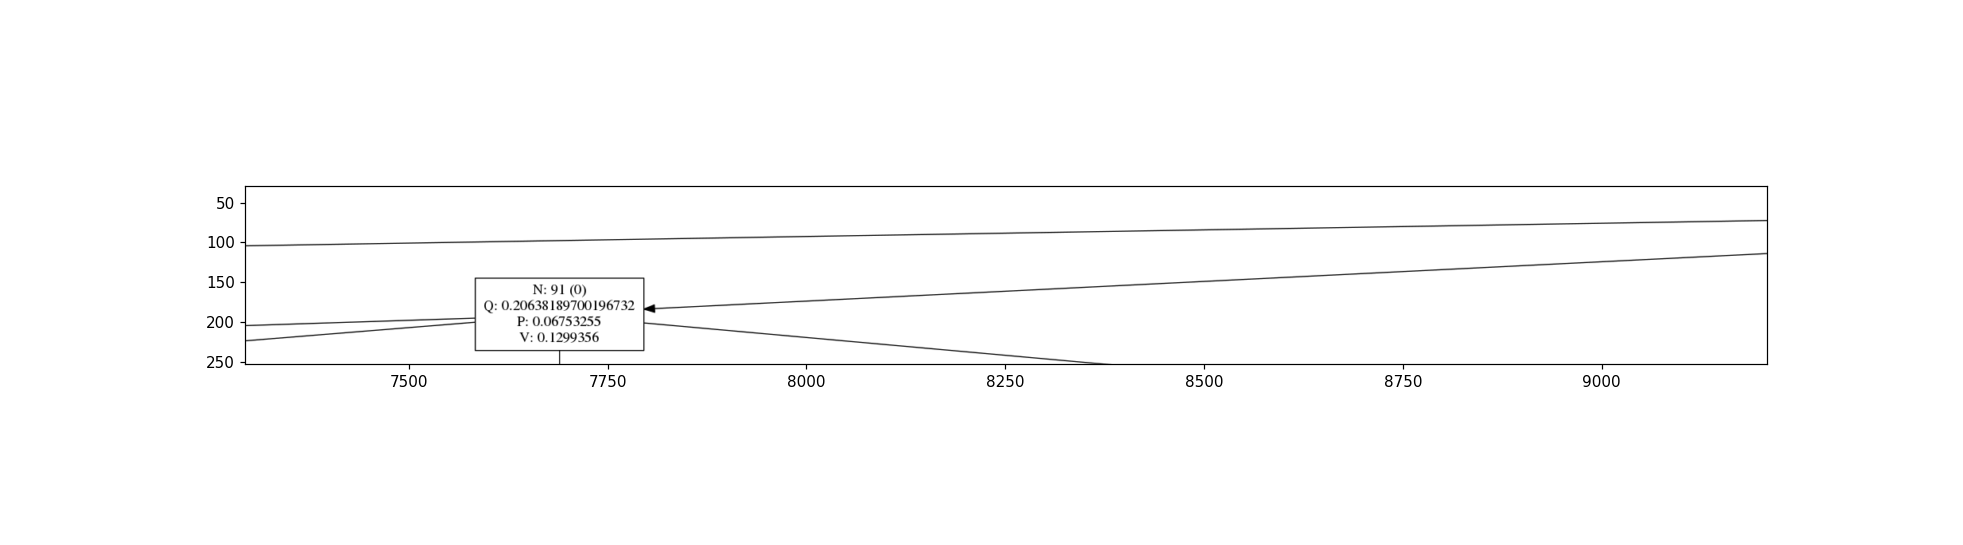

[0.05849423 0.07865313 0.06208936 0.09072018 0.06336358 0.05534982
 0.0611799  0.06147544 0.06835906 0.06753255 0.06238706 0.05642279
 0.08515063 0.06828925 0.07048902 0.05497073 0.05224065 0.06237349
 0.06844881 0.05480767 0.06113149 0.07009973 0.07771176 0.07069747
 0.05905243 0.061925   0.0601598  0.06105637 0.06262136 0.05609001
 0.05792445 0.06055666] [0. 1. 0. 1. 0.]
Color.EICHEL Value.UNTER => 0.090720184 (0.0)
Color.GRUEN Value.KOENIG => 0.06753255 (1.0)
Color.EICHEL Value.KOENIG => 0.07865313 (0.0)
Color.HERZ Value.SIEBEN => 0.07069747 (1.0)
Color.GRUEN Value.ZEHN => 0.08515063 (0.0)


In [64]:
predict([
    card(Color.EICHEL, Value.UNTER), 
    card(Color.GRUEN, Value.KOENIG),
    card(Color.EICHEL, Value.KOENIG),
    card(Color.HERZ, Value.SIEBEN),
    card(Color.GRUEN, Value.ZEHN),
    ],card(Color.GRUEN, Value.OBER), 0, 0)

# Play

In [84]:
def match(agents, render=False):
    obs, is_done = env.reset(), False    
    
    while not is_done:
        if agents[env.current_player] is None:
            state = env.get_state()
            prediction = calc_correct_output(env.players[env.current_player].hand_cards, env.table_card, env.players[env.current_player].tricks, env.players[1 - env.current_player].tricks)

            env.set_state(state)
            #print("1", prediction, env.players[env.current_player].hand_cards[np.argmax(prediction)].color.name, env.players[env.current_player].hand_cards[np.argmax(prediction)].value.name)
            a = env.players[env.current_player].hand_cards[np.argmax(prediction)].id

            #break
        else:
            prediction = agents[env.current_player].predict_single(obs)[0]
           # print("2", prediction)
            #print(prediction, np.argmax(prediction))
            valid_moves = np.array([1 if card in env.players[env.current_player].hand_cards else 0 for card in env.cards])       

            prediction_valid = np.ma.masked_where(valid_moves == 0, prediction)
            a = np.argmax(prediction_valid)
            #print(a)
            
            
                    
        obs, rew, is_done, _ = env.step(a)
        
        if render:
            env.render('human')
            sleep(1)
        #if env.lastTrick  is not None:
        #    break
    return env.current_player

def compare(agent1, agent2):
    agents = [agent1, agent2]
    first_player_wins = 0
    
    for i in range(1000):
        start_player = random.randint(0, 1)
        winner = match([agents[start_player], agents[1 - start_player]])
        first_player_wins += ((winner == 0) == (start_player == 0))
        #print(start_player, winner)
    
    return first_player_wins / 1000   

# Model

In [7]:
from keras.models import Sequential, clone_model
from keras.layers import Dense, Activation, Input, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Merge, Flatten, BatchNormalization, add
from keras.layers.merge import concatenate
from keras.models import Model

import keras.backend as K
from IPython.display import clear_output
from keras import optimizers
import math

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
class ImprovedModel(Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs, outputs)

    def predict_single(self, inputs):
        inputs = [np.expand_dims(input, 0) for input in inputs]
        outputs = self.predict(inputs)
        return [output[0] for output in outputs]

def mean_pred(y_true, y_pred):
    return K.mean(K.equal(K.gather(y_true, K.argmax(y_true, axis=-1)), K.gather(y_true, K.argmax(y_pred, axis=-1))))


def residual_layer(input_block, filters, kernel_size):

    x = conv_layer(input_block, filters, kernel_size)

    x = Conv2D(
    filters = filters
    , kernel_size = kernel_size
    , padding = 'same'
    , use_bias=False
    , activation='linear'
    )(x)

    #x = BatchNormalization(axis=1)(x)

    x = add([input_block, x])

    x = LeakyReLU()(x)

    return (x)

def conv_layer(x, filters, kernel_size):

    x = Conv2D(
    filters = filters
    , kernel_size = kernel_size
    , padding = 'same'
    , use_bias=False
    , activation='linear'
    )(x)

    #x = BatchNormalization(axis=1)(x)
    x = LeakyReLU()(x)

    return (x)

def build_model():
    
    input_1 = Input((4,8,2))
    convnet = input_1

    convnet = conv_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    convnet = residual_layer(convnet, 75, (3, 3))
    #convnet = conv_layer(convnet, 2, (1, 1))
    #convnet = Conv2D(32, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    #convnet = Conv2D(64, (3, 3), activation='relu', padding='same')(convnet)
    convnet = Flatten()(convnet)

    input_2 = Input((4,))

    policy_out = concatenate([convnet, input_2])
    #dense_out = Dense(128, activation='relu')(dense_out)
    #dense_out = Dense(256, activation='relu')(dense_out)
    #policy_out = Dense(256, activation='relu')(dense_out)
    policy_out = Dense(32, activation='sigmoid')(policy_out)

    value_out = concatenate([convnet, input_2])
    #dense_out = Dense(128, activation='relu')(dense_out)
    #dense_out = Dense(256, activation='relu')(dense_out)
    value_out = Dense(256, activation='relu')(value_out)
    value_out = Dense(1, activation='tanh')(value_out)

    model = ImprovedModel(inputs=[input_1, input_2], outputs=[policy_out, value_out])

    adam = optimizers.Adam()
    model.compile(optimizer=adam,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

# Train

<IPython.core.display.Javascript object>


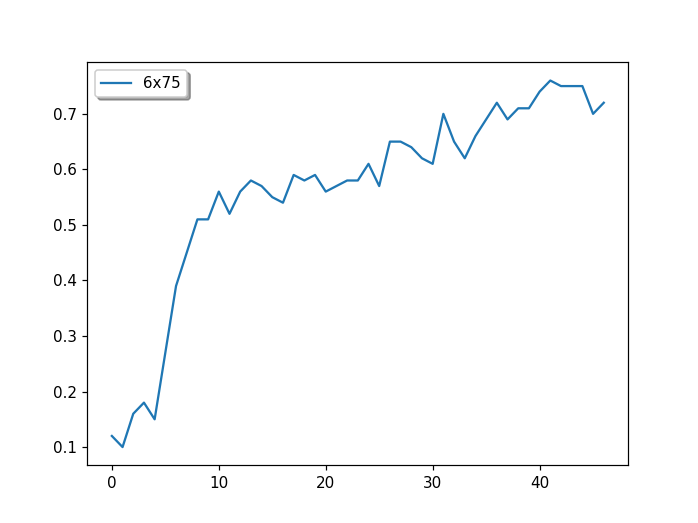

In [90]:
fig, ax = plt.subplots()

In [36]:
model = build_model()
trained_model = build_model()
trained_model.set_weights(model.get_weights())
#model.summary()

In [37]:
reset_samples()
eval_scores = [eval(trained_model, eval_cache_input, eval_cache_output)]
all_eval_scores = eval_scores[:]


In [31]:
reset_samples()

In [87]:
for i in range(1):  
    mcts_generate()
    clear_output()
    
    p = np.random.permutation(int(number_of_samples))
    if len(p) > BATCH_SIZE * TRAINING_LOOPS:
        p = p[:BATCH_SIZE * TRAINING_LOOPS]
    train_outputs = []
    train_inputs = []
    for i in range(len(sample_outputs)):
        train_outputs.append(sample_outputs[i][p])
    for i in range(len(sample_inputs)):
        train_inputs.append(sample_inputs[i][p])
        
    trained_model.fit(train_inputs, train_outputs, epochs=1, batch_size=BATCH_SIZE)    
    
    eval_new = eval(trained_model, eval_cache_input, eval_cache_output)
    if eval_new > eval_scores[-1]:
        eval_scores.append(eval_new)
        print("New model score: " + str(eval_scores[-1]) + "!")
        model.set_weights(trained_model.get_weights())
    print("Last scores: " + str(eval_scores[::-1]) + "!")
    all_eval_scores.append(eval_new)
    
plt.plot(all_eval_scores, label='6x75')
ax.legend(shadow=True)
plt.show()

Epoch 1/1
25600/25600 [==============================] - 48s 2ms/step - loss: 0.2464 - dense_10_loss: 0.0054 - dense_12_loss: 0.2410 - dense_10_acc: 0.5513 - dense_12_acc: 0.8484
Last scores: [0.76, 0.74, 0.72, 0.7, 0.65, 0.61, 0.59, 0.58, 0.56, 0.51, 0.45, 0.39, 0.27, 0.18, 0.16, 0.12]!


In [49]:
model_output = model.predict([sample_inputs[0], sample_inputs[1]])[0]
a = np.argmax(model_output, axis=-1)
k = np.equal(np.take(sample_outputs[0], np.argmax(sample_outputs[0], axis=-1)), np.take(sample_outputs[0], a)).sum()
k / len(sample_outputs[0])

0.8893666666666666

In [53]:
model.save('model.h5')

In [ ]:
model.load_weights('model.h5')

# Eval

In [ ]:
generate_training_data(100)    
p = np.random.permutation(len(sample_inputs))
sample_inputs, sample_outputs = sample_inputs[p], sample_outputs[p]

In [ ]:
model.evaluate(sample_inputs, sample_outputs)

# Predict

In [10]:
def generate_input(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    obs = [np.zeros([4, 8, 2]), np.zeros([4])]
    
    for card in hand_cards:
        obs[0][card.color.value][card.value.value][0] = 1
        
    if table_card is not None:
        obs[0][table_card.color.value][table_card.value.value][1] = 1

    obs[1][0] = (own_tricks == 1 or own_tricks == 3)
    obs[1][1] = (own_tricks == 2 or own_tricks == 3)

    obs[1][2] = (opponent_tricks == 1 or opponent_tricks == 3)
    obs[1][3] = (opponent_tricks == 2 or opponent_tricks == 3)
    
    return obs

In [11]:
def card(color, value):
    for card in env.cards:
        if card.value == value and card.color == color:
            return card
        
    return None

In [40]:
def calc_correct_output_sample(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    global sample_outputs
    env.reset()
    env.cards_left = env.cards[:]
    random.shuffle(env.cards_left)
    
    for card in hand_cards:
        env.cards_left.remove(card)
    env.players[0].hand_cards = hand_cards[:]
        
    env.players[1].hand_cards = []
    for i in range(len(hand_cards) - (1 if table_card is not None else 0)):
        env.players[1].hand_cards.append(env.cards_left.pop())       
    
    env.players[0].tricks = own_tricks
    env.players[1].tricks = opponent_tricks
    env.table_card = table_card
    
    root = State(1, env.get_state(), env.current_player)
    a, p = mcts_game_step(root, 100)
    env.set_state(root.env_state)
    print(p)
    draw_tree(root)
    #print("")
    #draw_path(root)
    #obs, rew, is_done, _ = env.step(hand_cards[0].id)
   # print(rew, is_done)

    #env.render('human')
    #root = State(1, env.get_state())
    #a, p = mcts_game_step(root, 1000, False)
    #draw_tree(root)
    #print("")
    #draw_tree(root.childs[0])
    
    #draw_path(root)
    #reset_samples(1)
    p = search(env.regenerate_obs())[1]
    #postprocess_samples()
        
    return p#sample_outputs[0]

In [13]:
def calc_correct_output(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):    
    correct_output = None
    for i in range(100):
        sample_outputs = calc_correct_output_sample(hand_cards, table_card, own_tricks, opponent_tricks)
        if correct_output is None:
            correct_output = sample_outputs
        else:
            correct_output += sample_outputs
    return correct_output / 100

In [14]:
def predict(hand_cards, table_card=None, own_tricks=0, opponent_tricks=0):
    input = generate_input(hand_cards, table_card, own_tricks, opponent_tricks)
    output = model.predict_single(input)[0]
    correct_output = calc_correct_output_sample(hand_cards, table_card, own_tricks, opponent_tricks)
    print(output,correct_output)
    id = 0
    for card in hand_cards:
        print(str(card.color) + " " + str(card.value) + " => " + str(output[card.id]) + " (" + str(correct_output[id]) + ")")
        id += 1

In [15]:
def create_eval_cache():
    eval_cache_input = []
    eval_cache_output = []
    for i in range(100):
        own_tricks = random.randint(0, 2)
        opponent_tricks = random.randint(0, 2)
        table_card_enabled = random.randint(0, 1)
        hand_cards = random.sample(env.cards, 5 - own_tricks - opponent_tricks + table_card_enabled)
        table_card = hand_cards.pop() if table_card_enabled else None

        eval_cache_input.append(generate_input(hand_cards, table_card, own_tricks, opponent_tricks))
        output = calc_correct_output(hand_cards, table_card, own_tricks, opponent_tricks)
        
        outputs_per_card = np.zeros((32,))
        for i in range(len(hand_cards)):
            outputs_per_card[hand_cards[i].id] = output[i]
            
        eval_cache_output.append(outputs_per_card)
        
    return eval_cache_input, eval_cache_output
        
def eval(model, eval_cache_input, eval_cache_output):
    correct = 0
    for i in range(len(eval_cache_input)):

        output = model.predict_single(eval_cache_input[i])[0]
        correct_output = eval_cache_output[i]
                    
        correct += correct_output[np.argmax(output)] == correct_output[np.argmax(correct_output)]
        #if correct_output[np.argmax(output)] != correct_output[np.argmax(correct_output)]:
        #    print(correct_output[np.argmax(output)], correct_output[np.argmax(correct_output)])
            
    return correct / len(eval_cache_input)


In [16]:
eval_cache_input, eval_cache_output = create_eval_cache()

In [18]:
with open('eval_cache', 'wb') as fp:
    pickle.dump([eval_cache_input, eval_cache_output], fp)

In [ ]:
with open ('eval_cache', 'rb') as fp:
    eval_cache_input, eval_cache_output = pickle.load(fp)

In [ ]:
eval(model, eval_cache_input, eval_cache_output)

[0.34343434 0.29292929 0.36363636]


<IPython.core.display.Javascript object>


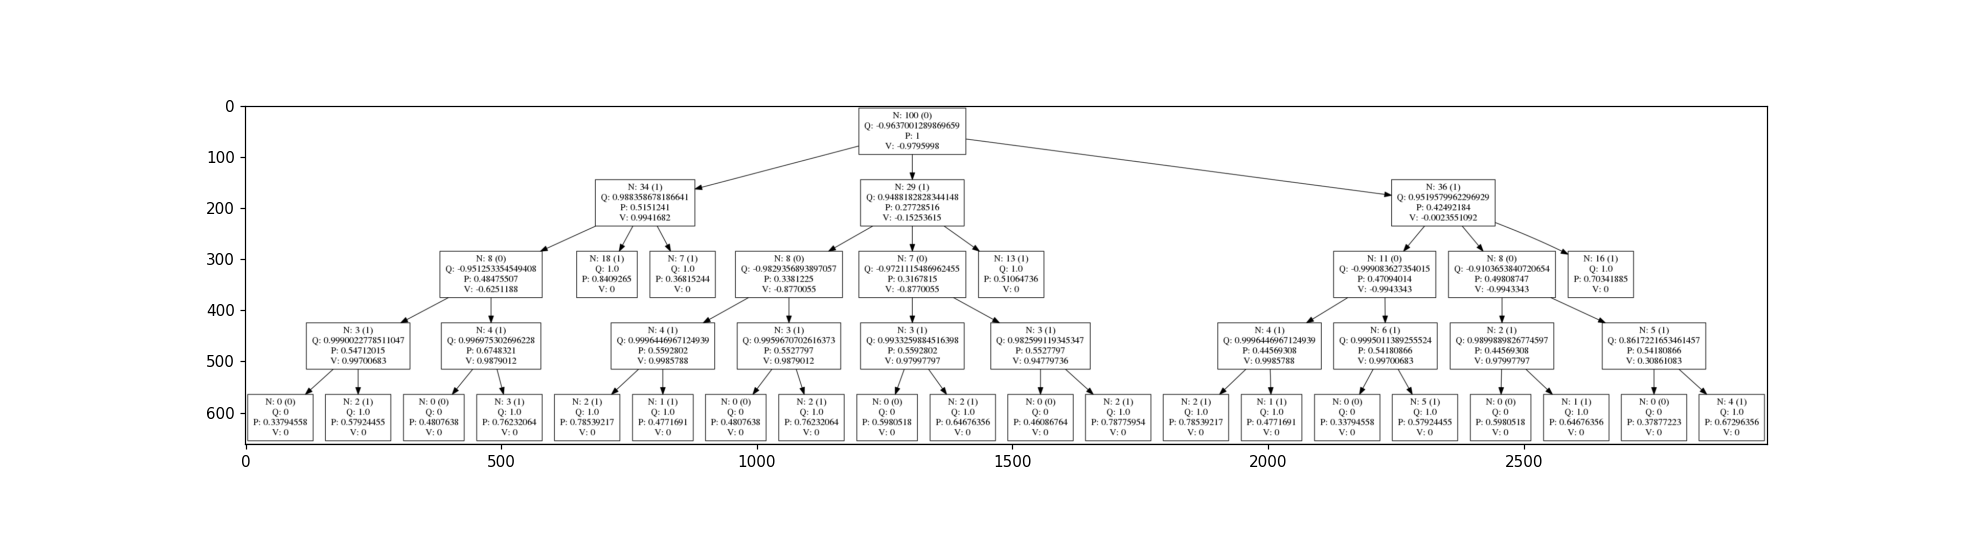

[0.01212645 0.27728516 0.01398775 0.01503888 0.01731289 0.0280111
 0.5151241  0.01016479 0.02686075 0.01720379 0.01071729 0.01348026
 0.01523335 0.01631631 0.03017392 0.0182105  0.42492184 0.01339474
 0.0190899  0.00972571 0.01319978 0.01309739 0.01107644 0.0180965
 0.00941624 0.01414633 0.01373501 0.01693242 0.01736209 0.01545741
 0.05496861 0.02283005] [0. 0. 0.]
Color.EICHEL Value.ACHT => 0.5151241 (0.0)
Color.EICHEL Value.KOENIG => 0.27728516 (0.0)
Color.HERZ Value.SAU => 0.42492184 (0.0)


In [48]:
predict([
    card(Color.EICHEL, Value.ACHT), 
    card(Color.EICHEL, Value.KOENIG),
    card(Color.HERZ, Value.SAU)
    ], None, 0, 2)


In [ ]:
calc_correct_output([
    card(Color.EICHEL, Value.UNTER), 
    card(Color.GRUEN, Value.KOENIG),
    card(Color.EICHEL, Value.KOENIG),
    card(Color.HERZ, Value.SIEBEN),
    card(Color.GRUEN, Value.ZEHN),
    ],card(Color.GRUEN, Value.OBER), 0, 0)

[0.51515152 0.05050505 0.05050505 0.04040404 0.34343434]


<IPython.core.display.Javascript object>


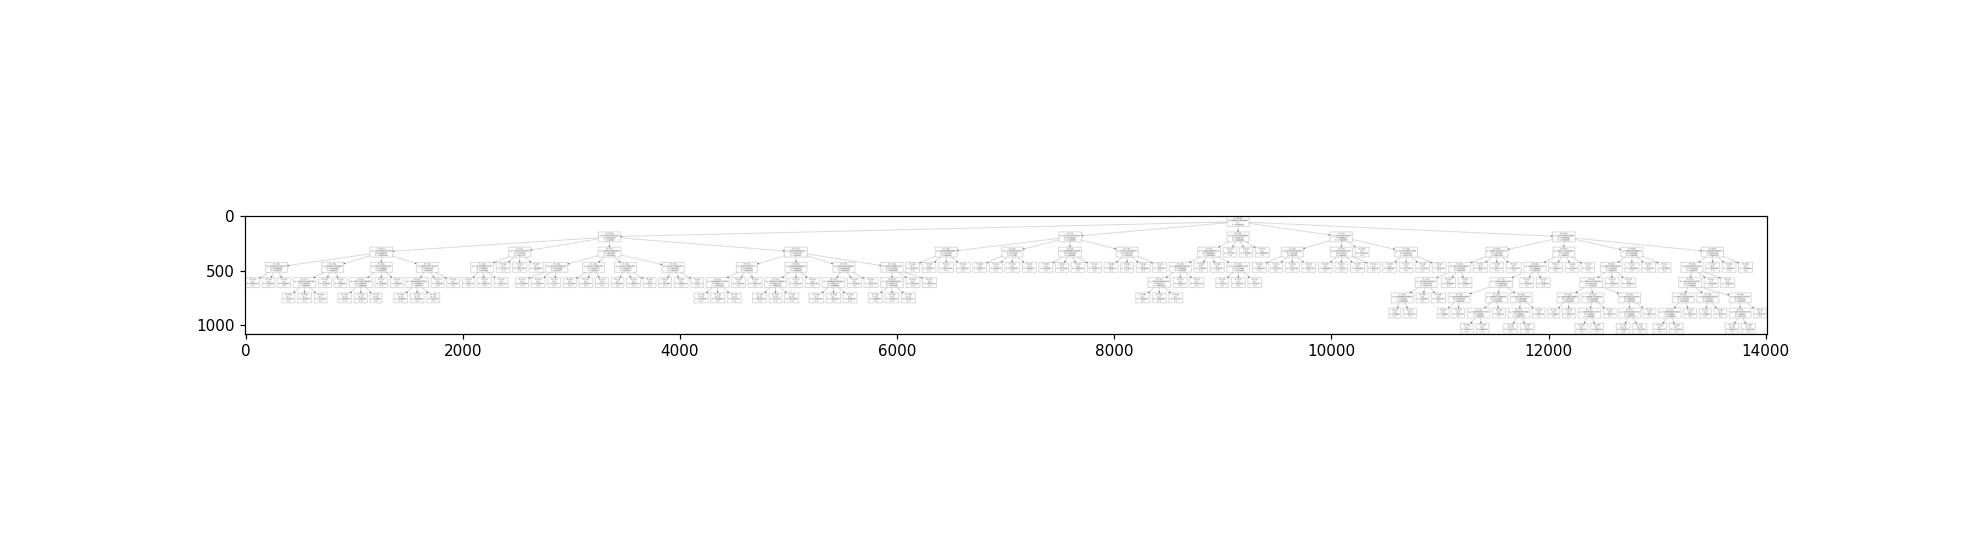

[4.9884468e-02 1.2747856e-04 8.3715696e-04 7.4461871e-04 8.0575881e-04
 5.5003073e-04 1.8478516e-03 2.4282802e-03 4.5447075e-04 7.3659867e-02
 4.0916592e-04 1.6487886e-01 8.9259300e-04 2.5161267e-03 2.2793934e-03
 5.0711061e-04 5.7803694e-04 4.6913885e-04 1.1687775e-03 9.2663069e-04
 7.6725916e-03 8.3509937e-04 1.4061715e-01 4.5544676e-02 3.2793107e-03
 5.0758091e-03 1.4634619e-03 5.1265868e-04 3.3348249e-04 4.6643373e-04
 3.1190640e-03 3.6930962e-04] [1. 1. 1. 1. 1.]
Color.HERZ Value.SIEBEN => 0.045544676 (1.0)
Color.GRUEN Value.KOENIG => 0.07365987 (1.0)
Color.HERZ Value.ACHT => 0.14061715 (1.0)
Color.EICHEL Value.SAU => 0.04988447 (1.0)
Color.GRUEN Value.UNTER => 0.16487886 (1.0)


In [92]:
predict([
    card(Color.HERZ, Value.SIEBEN), 
    card(Color.GRUEN, Value.KOENIG),
    card(Color.HERZ, Value.ACHT),
    card(Color.EICHEL, Value.SAU),
    card(Color.GRUEN, Value.UNTER),
    ],card(Color.SCHELLN, Value.OBER), 0, 0)

In [ ]:
hard_input = generate_input([
    card(Color.EICHEL, Value.UNTER), 
    #card(Color.GRUEN, Value.KOENIG),
    card(Color.EICHEL, Value.KOENIG),
    card(Color.HERZ, Value.SIEBEN),
    card(Color.GRUEN, Value.ZEHN),
    ],None, 1, 0)
model.predict_single(hard_input)

In [ ]:
for sample_input in sample_inputs[0]:
    if np.array_equal(sample_input,hard_input[0]):
        print("test")

In [ ]:
compare(model, build_model())

In [78]:
match([build_model(), model], True)

1